# GANs and Adversarial Examples

## **Introduction**

In this chapter, we will introduce another method of generating new data called Generative Adversarial Networks (GANs). A GAN is a framework that's used to generate new data by learning the distribution of data. It was first introduced by Ian Goodfellow et al. in the following landmark article, ***Generative Adversarial Nets***, available [here](https://arxiv.org/pdf/1406.2661.pdf)

The GAN framework is comprised of two neural networks, the **generator**, and **discriminator**, as seen in the following diagram:

![](gans.png)

In the **context of image generation**, the **generator generates fake data, when given noise as input**, and **the discriminator classifies real images from fake images**. **During training, the generator and the discriminator compete with each other in a game and as a result, get better at their jobs**. **The generator tries to generate better-looking images to fool the discriminator** and **the discriminator tries to get better at identifying real images from fake images**.

GANs are still evolving and new applications emerge every day. Some of these applications include **artistic image generation**, **data augmentation**, **image-to-image translation**, **super resolutions**, and **video synthesis**.

In this chapter, we will develop a GAN to generate new images similar to the **STL-10** dataset, using PyTorch. We will follow the **Deep Convolutional GAN (DCGAN) architecture** presented in the following paper, *Unsupervised representation learning with deep convolutional generative adversarial networks* available [here](https://arxiv.org/abs/1511.06434).

In addition, in this chapter, we will introduce **a vulnerability called adversarial examples or attacks**. **Adversarial examples are a type of input data that can significantly change a model prediction without being noticeable to the human eye**. Due to this fact, **adversarial examples can be worrisome, especially in critical tasks such as security or healthcare domains**. It would be beneficial to learn how these attacks work in order to start thinking about possible solutions.

### **Creating the dataset**

To train a GAN, we need a training dataset. Given a training dataset, the GAN will learn to generate new data with the same distribution as the training dataset. For instance, if we train a GAN on cat images, it will learn to generate new cat images that look real to our eyes. We will use the STL-10 dataset from the `torchvision` package. We used this dataset in *Chapter 3, Multi-Class Image Classification* for a multi-label classification task. Please see that chapter for more details about the dataset.

### **How to do it**

We will create an object of the STL-10 built-in dataset class and define a dataloader as follows:

In [34]:
# 1 Import the essential packages
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = '../data/STL/'
os.makedirs(path2data, exist_ok=True)

# 2 Define the data transformations
h, w = 64, 64
mean = (.5, .5, .5)
std = (.5, .5, .5)
transform = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.CenterCrop((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# 3 Instantiate an object of the STL-10 class
train_ds = datasets.STL10(path2data, split='train', download=False, transform=transform)
print(len(train_ds))

5000


In [35]:
# 4 Get a sample tensor from the dataset:
for x, _ in train_ds:
    print(x.shape, torch.min(x), torch.max(x))
    break

torch.Size([3, 64, 64]) tensor(-0.8980) tensor(0.9529)


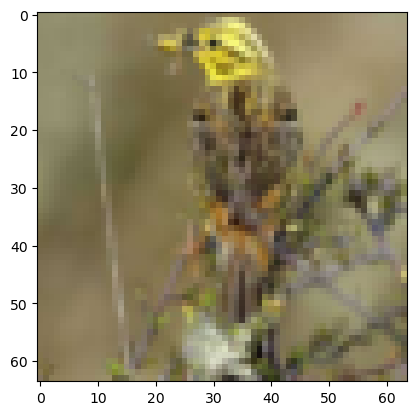

In [36]:
# 5 Let's display the sample tensor:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(to_pil_image(0.5*x+0.5))

In [47]:
# 6 Create the dataloader:
import torch

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 7 Get a data batch from the dataloader:
for x, y in train_dl:
    print(x.shape, y.shape)
    print(x.dtype, y.dtype)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])
torch.float32 torch.int64


### **How it works**

In step 1, we imported the essential packages and defined and created a folder to store the data upon downloading it.

In step 2, we defined the data transformations using the `torchvision.transforms` package. The original images might be in different sizes, thus we used a Resize transformation to resize images to $64 \times 64$. Next, `ToTensor` scales the image pixels to the range of `[0, 1]`. Next, we applied a normalization. The normalization `mean` and `std` values were set **to normalize inputs** to the range of `[-1, 1]`. As you will find out in Defining the Generator and Discriminator recipe, the output of the generator model is a tanh function that generates outputs in the range `[-1, 1]`.

> The output of the sigmoid activation function is in the range `[0, 1]`, while the output of the tanh activation function is in the range `[-1, +1]`.

In step 3, we instantiated an object of the `STL-10` class from the `torchvision.datasets` package. We passed the location of the data and `transformation` function to the class. As seen, the dataset has 5000 data samples.

In step 4, we got a sample image from the dataset and printed its shape and minimum and maximum values. As expected, the extracted sample is a PyTorch tensor in the shape of `(3, height, width)` and is normalized to the range of `[-1, 1]`.

In step 5, we displayed the sample image. Notice that since the tensor was normalized to `[-1, 1]`, we had to re-normalize it for visualization purposes, as otherwise, the image would look saturated.

In step 6, we defined a dataloader. The batch size was set to $32$. However, you can adjust it based on your computer and GPU memory.

> If you run into memory errors when training a model, try reducing the batch size.

In step 7, we extracted a sample mini-batch from the dataloader and printed its shape. 

## **Defining the generator and discriminator**

**The GAN framework is based on the competition of two models**, namely, **the generator and discriminator**. <font color=yellow>The generator generates fake images and the discriminator tries to identify real images from fakes images</font>. As a result of this competition, <font color=yellow>the generator will generate better-looking fake images while the discriminator will become better at identifying them</font>.

As mentioned at the beginning of this chapter, we will follow the `DCGAN` framework. Based on `DCGAN`, **the architecture of the discriminator is similar to binary classification models based on convolutional layers**. We developed a binary classification model in Chapter 2, Binary Image Classification, although here, pooling layers are replaced with stridden convolution layers.

![](generator_architecture.png)

In this recipe, you will learn how to implement the generator and discriminator models of our GAN framework.

### **How to do it**

We will define the generator and discriminator models and initialize their weights:

In [38]:
## 1 Define the Generator class
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        nz = params["nz"]
        ngf = params["ngf"]
        noc = params["noc"]
        self.dconv1 = nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d(ngf, noc, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))            
        x = F.relu(self.bn3(self.dconv3(x)))        
        x = F.relu(self.bn4(self.dconv4(x)))    
        out = torch.tanh(self.dconv5(x))
        return out

In [39]:
# 2 Define an object of the Generator class:
params_gen = {
        "nz": 100,
        "ngf": 64,
        "noc": 3,
    }
model_gen = Generator(params_gen)
device = torch.device("cuda")
model_gen.to(device)
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [40]:
# Let's pass some dummy input to the model:
with torch.no_grad():
    y = model_gen(torch.zeros(1, 100, 1, 1, device=device))
print(y.shape) 

torch.Size([1, 3, 64, 64])


In [48]:
# 3 Define the Discriminator class:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        nic = params["nic"]
        ndf = params["ndf"]
        self.conv1 = nn.Conv2d(nic, ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)            
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace = True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace = True)
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

In [50]:
# 4 Define an object of the Discriminator class:
params_dis = {
    "nic": 3,
    "ndf": 64,
}
model_dis = Discriminator(params_dis)
model_dis.to(device)
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [51]:
# Let's pass some dummy input to the model:
with torch.no_grad():
    y = model_dis(torch.zeros(1, 3, h, w, device=device))
print(y.shape)  

torch.Size([1])


In [52]:
# 5 Define a helper function to initialize the model weights:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 6 nitialize the model weights by calling the helper function:
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

### **How it works**

In step 1, we defined the Generator class with two methods. In the __init__ method, we defined the layers. The function has one input argument, params, which is a Python dictionary with the following keys:

* `nz`: The **size of the input noise vector (set to $100$)**
* `ngf`: A **coefficient for the number of convolutional filters in the generator** (set to $64$)
* `noc`: **The number of output channels** (set to $3$ for RGB images)

As seen, $5$ `conv-transpose` layers were defined. A `conv-transpose` layer is **also called a fractionally-strided convolution or a deconvolution**. They are **used to upsample the input vector to the desired output size**.

In the `forward` method, we **defined the connections between the layers and got the output**. T**he output of `Generator` is a tensor of shape `(batch_size, 3, height, width)`**.

In step 2, we defined an object of the `Generator` class called model_gen. To make sure that the model was created properly, we passed some dummy input to the generator model. As expected, the model output is a tensor of shape `[1, 3, 64, 64]`.

In step 3, we defined the `Discriminator` class. Similarly, in the `__init__` method, we defined the layers and in the `forward` method, **we defined the connections between the layers**. Notice that **we did not use any pooling layers and instead set the `stride` argument to $2$ or $4$ to downsample the input size**. Also, notice that **`leaky_relu` activation was used instead of `relu` to reduce overfitting**.

In step 4, we defined an object of the `Discriminator` class. To make sure that the model was created properly, we passed some dummy input to the discriminator model. This simple test will help fix any possible errors before we move on to the next steps.

In step 5, we defined a helper function to initialize the model weights. The input to the function was a PyTorch model. The DCGAN paper suggested initializing the weights using a normal distribution with `mean=0` and `std=0.02`, as we did in the helper function.

In step 6, we applied an `initialize_weights` helper function to the generator and discriminator models to **initialize their weights**.

## **Defining the loss and optimizer**

For the models to learn, we need to define a criterion. **The discriminator model is a classification network** and we can use the **binary cross-entropy (BCE)** loss function as its criterion. **For the generator model to learn, we pass its output to the discriminator model and then evaluate the output of the discriminator model**. Thus, **the same BCE loss function can be used as a criterion to train the generator model**. Also, we will use the Adam optimizer to update the parameters of the discriminator and generator models.

In this recipe, you will learn how to define the loss function and optimizer of a GAN network.

### **How to do it**

We will define the loss function and optimizer:

In [53]:
import torch.optim as optim
# 1 Define an object of the BCE loss class:
loss_func = nn.BCELoss()
# 2 Define the optimizer for the generator:
lr = 2e-4 
beta1 = 0.5
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, 0.999))
# 3 Define the optimizer for the discriminator:
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, 0.999))

### **How it works**

In step 1, we defined the **BCE** criterion from the `torch.nn` package to calculate the BCE loss between the target and the output. As you will see in the next section, we will use this loss function in multiple steps.

In step 2, we defined the `Adam` optimizer from `torch.optim` for the generator model based on the hyperparameters suggested in the DCGAN paper. The paper suggested setting the learning rate to $0.0002$ and the momentum term `beta1` to $0.5$ for training stability.

Similarly, in step 3, we defined the `Adam` optimizer from `torch.optim` for the discriminator model.

## **Training the models**

Training the GAN framework is done in two stages: training the discriminator and training the generator. To this end, we will take the following steps:

1. Get a batch of real images with the target labels set to 1.
2. Generate a batch of fake images using the generator with the target labels set to 0.
3. Feed the mini-batches to the discriminator and compute the loss and gradients.
4. Update the discriminator parameters using the gradients.
5. Generate a batch of fake images using the generator with the target labels set to 1.
6. Feed the fake mini-batch to the discriminator and compute the loss and gradients.
7. Update the generator only based on gradients.
8. Repeat from step 1.

In this recipe, you will learn how to implement these steps.

### **How to do it**

In [61]:
# 1 Define a few parameters:
real_label = 1
fake_label = 0
nz = params_gen["nz"]
num_epochs = 100

loss_history={"gen": [], "dis": []}

# 2 Start the training loop and calculate the loss for real samples:
batch_count = 0
for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        model_dis.zero_grad()
        xb = xb.to(device)
        yb = torch.full((ba_si,), real_label, device=device)
        out_dis = model_dis(xb)
        loss_r = loss_func(out_dis.to(torch.float32), yb.to(torch.float32))
        loss_r.backward()
        noise = torch.randn(ba_si, nz, 1, 1, device=device)
        out_gen = model_gen(noise)
        out_dis = model_dis(out_gen.detach())
        yb.fill_(fake_label)    
        loss_f = loss_func(out_dis.to(torch.float32), yb.to(torch.float32))
        loss_f.backward()
        loss_dis = loss_r + loss_f
        opt_dis.step()
        model_gen.zero_grad()
        yb.fill_(real_label)  
        out_dis = model_dis(out_gen)
        loss_gen = loss_func(out_dis.to(torch.float32), yb.to(torch.float32))
        loss_gen.backward()
        opt_gen.step()
        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())
        batch_count += 1
        if batch_count % 100 == 0:
            print(epoch, loss_gen.item(), loss_dis.item())

0 2.990412473678589 0.623089075088501
1 6.454342842102051 0.2632676661014557
1 10.061540603637695 0.8002391457557678
2 2.872751235961914 1.1049304008483887
3 2.711747169494629 0.5622832775115967
3 4.315584659576416 0.13007357716560364
4 6.031122207641602 0.14040285348892212
5 6.554966926574707 0.6768488883972168
5 1.177929162979126 1.670720100402832
6 6.343755722045898 0.8183460235595703
7 4.601901054382324 0.5662260055541992
7 4.221216678619385 0.17919135093688965
8 2.0421700477600098 0.13765043020248413
8 3.2686729431152344 0.9217780232429504
9 4.6716389656066895 0.22203510999679565
10 4.0258402824401855 0.14585912227630615
10 4.925878524780273 0.7081034183502197
11 5.203848838806152 0.2234269380569458
12 3.8412232398986816 0.6056177616119385
12 7.443761825561523 0.663023054599762
13 1.2296240329742432 0.835398256778717
14 6.873876571655273 0.49776721000671387
14 2.0143003463745117 0.7889825105667114
15 2.9106204509735107 0.7092198133468628
15 2.831881046295166 1.056061029434204
16 3

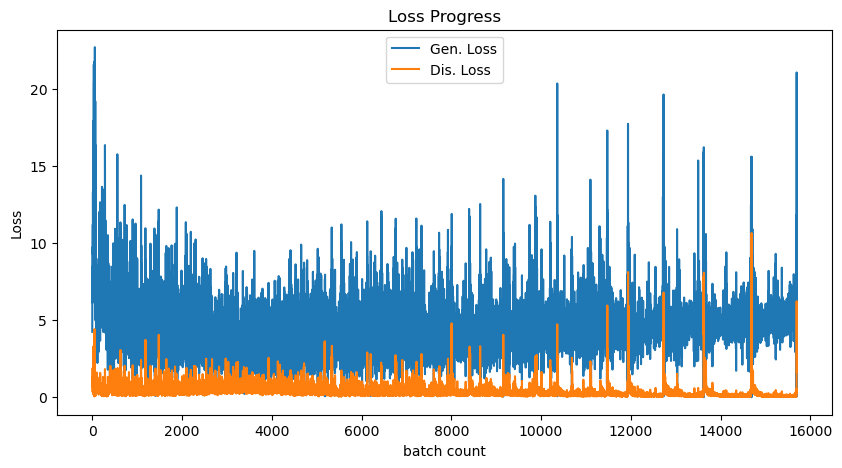

In [62]:
# 3 Plot the loss history:
plt.figure(figsize=(10,5))
plt.title("Loss Progress")
plt.plot(loss_history["gen"], label="Gen. Loss")
plt.plot(loss_history["dis"], label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
# 4 Store the model weights:
import os

path2models = "../models/"
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, "weights_gen.pt")
path2weights_dis = os.path.join(path2models, "weights_dis.pt")

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

### **How it works**

In step 1, we defined a few parameters. We defined `real_label` and `fake_label` and set them to $1$ and $0$, respectively. Later, we will need to label a mini-batch using these parameters. The nz parameter specifies the size of the input noise vector to the generator model. This was set to $100$ in Defining the generator and discriminator recipe. The `num_epochs` parameter specifies how many times we want to iterate over the training data. To store the loss values for the discriminator and generator models, we defined the `loss_history` dictionary.

In step 2, we implemented the training loop. The training loop iterates over the real dataset for `num_epochs`. In each epoch, we got a batch of real images from `celeb_dl` and fed it to the discriminator model and got its output as `out_dis`. Note that here, the real images were labeled with `real_label` using the `torch.full` method. Then, the loss value for the real mini-batch was calculated as `loss_r`. Next, the gradients of `loss_r` with respect to the discriminator parameters were calculated in a backward pass.

Next, we generated a mini-batch of fake images using the generator and fed them to the discriminator. In passing the output of the generator to the discriminator, we used the `.detach()` method to **avoid gradient tracking for the generator model**. Note that at this point, the fake images were labeled with `fake_label` using the `torch.fill_` method. Then, the loss value for the fake mini-batch was calculated as `loss_f`. Next, the gradients of `loss_f` with respect to the discriminator parameters were calculated in a backward pass.

Finally, we updated the discriminator parameters using the `.opt_dis.step()` method.

Next, we trained the generator model. To this end, we passed the fake images to the discriminator model and got its output. Note that here, the fakes images were labeled with `real_label` using the `.fill_` method. This may sound strange at first, but it is done to force the generator model to generate better-looking images.

> Even though the outputs of the generator model are fake, we used real_label as the target value when computing the loss value.

Then, we calculated the loss value as `loss_gen`, computed its gradients, and updated the generator parameters using `opt_get.step()`. By executing the code, the loss values were printed on the screen.

In step 3, we plotted the generator and discriminator loss values during training.

In step 4, we stored the trained weights into pickle files for future use.

### **See also**

There has been significant progress on GANs in recent years to increase the quality and dimension of generated data. As an example, you can refer to the following paper:

* StyleGAN: ***A Style-Based Generator Architecture for Generative Adversarial Networks***, available [here](https://arxiv.org/abs/1812.04948).
This paper is from NVIDIA and combined progressive GANs and neural style transfer to generate high-quality images.

Check out a PyTorch implementation of the paper [here](https://github.com/rosinality/style-based-gan-pytorch).

## **Deploying the generator**

Once we've trained a GAN, we end up with two trained models. Usually, we discard the discriminator model and keep the generator model. We can use the trained generator to generate new images. To deploy the generator model, we load the trained weights into the model and then feed it with random noise. Make sure to define the model class beforehand. To avoid repetition, we will not define the model class here.

### **How to do it**

We will load the weights into the generator model and generate new images:

In [70]:
# 1 Load the weights:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# 2 Set the model in evaluation mode:
model_gen.eval()

# 3 Feed noise to the model and get its outputs:
with torch.no_grad():
    fixed_noise = torch.randn(16, nz, 1, 1, device=device)
    img_fake = model_gen(noise).detach().cpu()    
print(img_fake.shape)


torch.Size([8, 3, 64, 64])


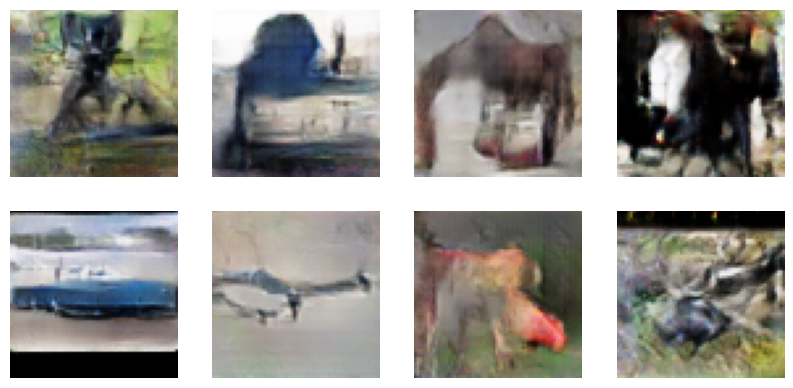

In [71]:
# 4 Display the generated images:
plt.figure(figsize=(10, 10))
for ii in range(8):
    plt.subplot(4, 4, ii + 1)
    plt.imshow(to_pil_image(0.5 * img_fake[ii] + 0.5))
    plt.axis("off")

### **How it works**

In step 1, we loaded the trained weights from the `pickle` file into the generator model. In step 2, we set the model in evaluation mode. In step 3, we fed random noise vectors into the model and received generated fake images. In step 4, we displayed the generated faked images.

> Note that we had to re-normalize the output tensor back to its original values for visualization purposes.

Check out the generated images. Some of them may look very distorted, while others look relatively realistic. To improve the results, **you can train the model on a single class of data as opposed to multiple classes together. GANs perform better when they are trained with a single class**. The STL-10 dataset has multiple classes. Try to select one category and the train the GAN models. Also, you can try to train the model for a longer time and see how that changes the generated images.

## **Attacking models with adversarial examples**

In the previous chapters, such as *Chapters 2* to *6*, we have seen the power of deep learning models to solve various computer vision tasks. We trained and then tested multiple models on different datasets. Now, we are going to turn our attention to the robustness of these models.

In this recipe, we want to introduce a vulnerability called adversarial examples or attacks. Adversarial examples are a type of input data that can significantly change the model prediction without being noticeable to the human eye. Due to this fact, adversarial examples can be worrisome, especially in critical tasks such as the security or healthcare domains. It would be beneficial to learn how these attacks work in order to start thinking about possible solutions.

An example of an adversarial attack is shown in the following screenshot:

![](adversarial_attack.png)

The **image on the left is an original image**, while **the image on the right is an adversarial version of the same image**. **Even though both images look the same, the predicted probabilities by a classifier, shown on the titles, are significantly different**. In this chapter, we will develop such an adversarial attack.

There are $2$ types of adversarial attacks: **white-box** and **black-box attacks**. In **white-box attacks, the attacker has the knowledge of the model, input, and loss function** that was used to train the model. By using this knowledge, **the attacker can change the inputs to disrupt the predicted outputs. The amount of change in the input is usually minor and indistinguishable to the human eye**. A **common type of white-box attack is called the Fast Gradient Sign (FGS) attack, which works by changing the input to maximize the loss.**

In the **FGS attack, given an input and a pre-trained model, we compute the gradients of the loss with respect to the input**. Then, we **add a small portion of the absolute value of gradients to the input**.

In this recipe, you will learn how to develop an FGS attack for the binary classification model presented in Chapter 2, Binary Image Classification, of this book. As you may recall, we developed a classifier on the Histo dataset to classify cancerous images. We will use the same dataset and trained model here for our purposes. See Chapter 2, Binary Image Classification, for all the details.

### **Getting Ready**

#### **How to do it**

We will load the dataset, load the pre-trained model, and implement the FGS attack.